# 1. Data preparation

## 1.1 Import Libraries 

In [2]:
library(data.table, quietly = TRUE, warn.conflicts = FALSE) # for fast data processing
library(dplyr) # data manipulation
library(ggplot2) #data visualization
library(ggmap)
library(RColorBrewer)
library(lubridate)
library(chron) #handling of dates
library(rgdal, quietly = TRUE, warn.conflicts = FALSE) 
library(scales)

## 1.2 Helper functions

In [3]:
library(grid)
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)), ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,layout.pos.col = matchidx$col))
    }
  }
}

## 1.3 Import data

In [4]:
data <- fread('c:/datasets/NYCtaxi_cleaned_data.csv', sep=",", stringsAsFactors=F)

data <- data %>%
  mutate_at("pickup_county", funs(as.factor)) %>% 
  mutate_at("dropoff_county", funs(as.factor)) %>% 
  mutate_at("dataset", funs(as.factor)) %>% 
  mutate_at("holiday", funs(as.factor)) %>% 
  mutate(date         = date(date), 
         weekday      = lubridate::wday(date, label=TRUE),
         weekend      = is.weekend(date),
         month        = month(date, label = TRUE, abbr = FALSE))

str(data)

Read 1815361 rows and 25 (of 25) columns from 0.324 GB file in 00:00:13
'data.frame':	1815361 obs. of  25 variables:
 $ passenger_count     : int  1 1 1 1 1 4 1 1 1 4 ...
 $ pickup_longitude    : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude     : num  40.8 40.7 40.8 40.7 40.8 ...
 $ pickup_county       : Factor w/ 5 levels "Bronx","Hudson",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ dropoff_longitude   : num  -74 -74 -74 -74 -74 ...
 $ dropoff_latitude    : num  40.8 40.7 40.7 40.7 40.8 ...
 $ dropoff_county      : Factor w/ 5 levels "Bronx","Hudson",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ trip_duration       : int  455 663 2124 429 435 341 255 1225 1274 1128 ...
 $ dataset             : Factor w/ 2 levels "test","train": 2 2 2 2 2 2 2 2 2 2 ...
 $ pickup_neighborhood : chr  "Midtown" "Gramercy" "Midtown" "Tribeca" ...
 $ dropoff_neighborhood: chr  "Upper East Side" "Greenwich Village" "Financial District" "Financial District" ...
 $ dist                : num  1.5 1.81 6.39 1.49 1.19 1.33 1.31 5.13 3.81 

# 2. Weather Conditions

 Weather conditions are another factor to understand the passenger flow on the city. For precipitation, once outliers have been removed (6 observations with precipitation over 20mm in a day), there is a slight downward trend of taxi services on average (A). This can be explained by a decreased eagerness of passengers to go out during rainy days. Traffic also tends to go slower on average on rainy days (B), decreasing over 1km/h for days when precipitation is over 10mm. Trips also tend to take longer on average (C) given the slower velocities of the traffic on rainy days.
For snow depth, the results are similar to the precipitation conditions. Average passenger count (D) and average speed (E) decrease and average trip duration increases (F) as the snow depth increases. However, these finds are less 


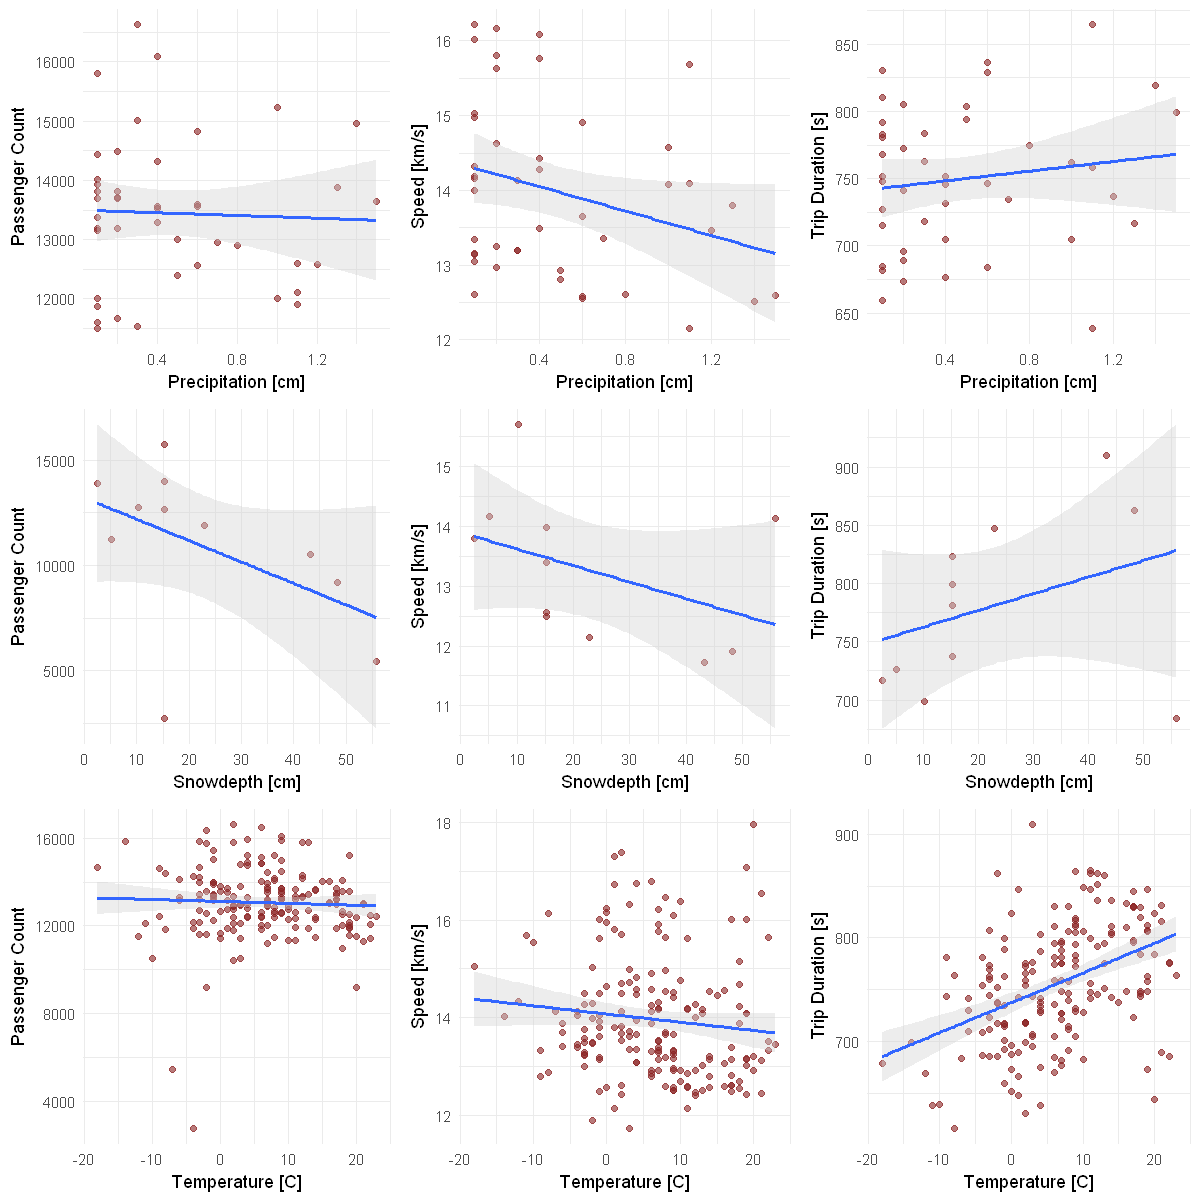

In [6]:
p1 <- data %>%
    group_by(date,precipitation) %>%
    summarise(trip_duration = sum(passenger_count)) %>% 
    filter(precipitation > 0 & precipitation  < 1.7) %>% 
    ggplot(aes(precipitation, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Precipitation [cm]", y = "Passenger Count")

p2 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,precipitation) %>%
    summarise(speed = mean(speed)) %>% 
    filter(precipitation > 0 & precipitation  < 1.7) %>% 
    ggplot(aes(precipitation, speed)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Precipitation [cm]", y = "Speed [km/s]")

p3 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,precipitation) %>%
    summarise(trip_duration = mean(trip_duration)) %>% 
    filter(precipitation > 0 & precipitation  < 1.7) %>% 
    ggplot(aes(precipitation, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Precipitation [cm]", y = "Trip Duration [s]")

p4 <- data %>%
    group_by(date,snowdepth) %>%
    summarise(trip_duration = sum(passenger_count)) %>% 
    filter(snowdepth > 0) %>% 
    ggplot(aes(snowdepth, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Snowdepth [cm]", y = "Passenger Count")

p5 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,snowdepth) %>%
    summarise(speed = mean(speed)) %>% 
    filter(snowdepth > 0) %>% 
    ggplot(aes(snowdepth, speed)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Snowdepth [cm]", y = "Speed [km/s]")

p6 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,snowdepth) %>%
    summarise(trip_duration = mean(trip_duration)) %>% 
    filter(snowdepth > 0) %>% 
    ggplot(aes(snowdepth, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Snowdepth [cm]", y = "Trip Duration [s]") 

p7 <- data %>%
    group_by(date,minTemp) %>%
    summarise(trip_duration = sum(passenger_count)) %>%  
    ggplot(aes(minTemp, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Temperature [C]", y = "Passenger Count")

p8 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,minTemp) %>%
    summarise(speed = mean(speed)) %>% 
    ggplot(aes(minTemp, speed)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Temperature [C]", y = "Speed [km/s]")

p9 <- data %>%
    filter(dataset=="train") %>%
    group_by(date,minTemp) %>%
    summarise(trip_duration = mean(trip_duration)) %>% 
    ggplot(aes(minTemp, trip_duration)) +
    theme_minimal() +
    geom_point(alpha = 0.6, color="brown4") +
    geom_smooth(method = "lm", span = .1, fill="lightgray") +
    labs(x = "Temperature [C]", y = "Trip Duration [s]") 

options(repr.plot.width=10, repr.plot.height=10) #Graph sizing in jupyter,for rstudio is not required
layout <- matrix(c(1,2,3,4,5,6,7,8,9),3,3,byrow=TRUE)
multiplot(p1,p2,p3,p4,p5,p6,p7,p8,p9, layout=layout)